In [35]:
import requests
import json
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd

base_url = "https://monitor.protezionecivile.fvg.it/api"

First, let's get familiar with the api.

In [36]:
def get_ids(from_date, to_date, radar_id=1, last = 10000, offset = 0):
    # radar 1 is the one with more observations: VMI and SRI are the most interesting

    endpoint = f"/radars/{radar_id}/products"
    url = base_url + endpoint

    params = {
        "from": from_date, 
        "to": to_date,
        "last": last,
        "offset": offset
    }

    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        
        data = response.json()
        # print(json.dumps(data, indent=4))
        
        # visualize the data using a df
        if data is not None:
            try:
                products = data.get("products", [])
                selected_data = [
                    {
                        "id": product.get("id"),
                        "name": product.get("name"),
                        "format": product.get("format"),
                        "date_time": product.get("dt")
                    }
                    for product in products
                ]

                df = pd.DataFrame(selected_data)
            except:
                print(data)
                df = None

        else :
            df = None

    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")

    return df

In [37]:
get_ids("2024-10-24 03:00:00", "2024-10-24 03:01:00", radar_id=1, last=10000, offset=0)

,id,name,format,date_time
0,2447750,VMI,application/x-hdf5,2024-10-24 03:00:00
1,2447751,VMI,image/png,2024-10-24 03:00:00
2,2447752,HVMI,application/x-hdf5,2024-10-24 03:00:00
3,2447753,HVMI_NS,image/png,2024-10-24 03:00:00
4,2447754,HVMI_OE,image/png,2024-10-24 03:00:00
5,2447755,SRI,application/x-hdf5,2024-10-24 03:00:00
6,2447756,SRI,image/png,2024-10-24 03:00:00
7,2447757,SRILBM,application/x-hdf5,2024-10-24 03:00:00
8,2447758,SRILBM,image/png,2024-10-24 03:00:00
9,2447759,SRISV,application/x-hdf5,2024-10-24 03:00:00


VMI is the radar-detected maximum vertical reflectivity 

SRI is the Surface Rainfall Intensity

The SRT variable is the radar-detected precipitation cumulated on different durations

The SSI variable is the radar-detected storm severity index

HMC and LBM_V should be something about the wind

In [38]:
def get_image_product(product_id, file_name):
    endpoint = f"/products/{product_id}"
    url = base_url + endpoint
    headers = {
    "accept": "image/jpeg",
    }
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
        with open(file_name, "wb") as file:
            file.write(response.content)

    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")

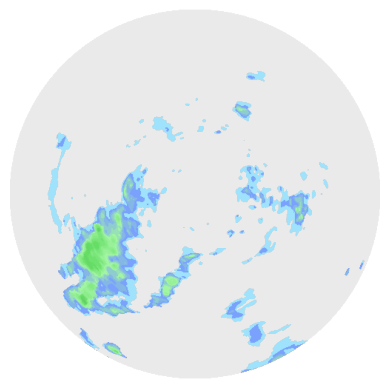

In [41]:
get_image_product(2447756, "images/2447756.jpg")

# Load and display the image
image_path = "images/2447756.jpg"
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

## Creating a df for the indexes of the product of interest

I decided to use the surface rainfall intensity because SRI the size of the images is smaller [500,500] than the size of the vertical reflectivity index VMI [2000,2000]

In [140]:
year = 2024
data_frames = []

for month in range(4, 11):
    max_day = 31
    id_df = pd.DataFrame()
    print(f"Month: {month}")
    if month == 4 or month == 6 or month == 9 or month == 11:
        max_day = 30
    for from_date in pd.date_range(f"{year}-{month}-01 00:00:00", f"{year}-{month}-{max_day} 00:00:00", freq="1D"):
        to_date = from_date + pd.Timedelta(days=1)
        try:
            df = get_ids(from_date, to_date, radar_id=1, last=10000, offset=0)
            if df is None:
                continue
        except requests.exceptions.RequestException as e:   
            print(f"An error occurred: {e}")
            continue
        # filter the data: keep only the products with the name "SRI" and jpeg format
        if not df.empty:
            df = df[df["name"].isin(["SRI"]) & (df["format"] == "image/png")]
        id_df = pd.concat([df,id_df], ignore_index=True)

    globals()[f"id_df_{month}"] = id_df
    data_frames.append(id_df)

Month: 4
Month: 5
Month: 6
Month: 7
Month: 8
Month: 9
Month: 10


In [188]:
data_frames = data_frames[::-1]
id_df = pd.concat(data_frames, ignore_index=True)
id_df = id_df.drop(columns=["name", "format"])
# keep only unique values of the df wrt id
id_df = id_df.drop_duplicates(subset=['id'])

# save the dataframe to a csv file
id_df.to_csv("id_df_SRI_jpg_radar_1.csv", index=False)

A possible way to distinguish if an image represents an interesting rainfall would be to check the colours of the image, but it is not efficient. A smarter approach is to check the time of each image: during a rainfall the radar produces images more often. This is not always true, but it works in many cases.

In [61]:
# analyse an image to find the unique colors and their counts
image_path = 'images/2461494.jpg'
image = mpimg.imread(image_path)

# If the image is RGBA, convert it to RGB by removing the alpha channel
if image.shape[-1] == 4:
    image = image[..., :3]

# Reshape the array to a list of RGB values
pixels = image.reshape(-1, image.shape[-1])

# Find unique colors and their counts
unique_colors, counts = np.unique(pixels, axis=0, return_counts=True)

# Print the unique colors and their counts
for color, count in zip(unique_colors, counts):
    print(f"Color: {color}, Count: {count}")

Color: [0. 0. 0.], Count: 861174
Color: [0.         0.09019608 0.99607843], Count: 4
Color: [0.         0.19215687 0.9882353 ], Count: 45
Color: [0.         0.20392157 0.9882353 ], Count: 8
Color: [0.         0.28235295 0.9843137 ], Count: 5
Color: [0.         0.33333334 0.9843137 ], Count: 12
Color: [0.         0.34901962 0.9843137 ], Count: 25
Color: [0.         0.37254903 0.98039216], Count: 32
Color: [0.         0.4        0.98039216], Count: 5
Color: [0.         0.42745098 0.98039216], Count: 28
Color: [0.         0.46666667 0.98039216], Count: 7
Color: [0.3137255 0.3137255 0.3137255], Count: 3138655


In [185]:
pd.set_option('display.max_rows', None) 
# create a new column of the dataframe named "storm" and set it to true if the previous image has a time less than 30 minutes
# the first image of the dataframe will have the "storm" column set to False

# Convert 'time' columns to time, format is hour:minute:second
id_df['date_time'] = pd.to_datetime(id_df['date_time'], format='%Y-%m-%d %H:%M:%S')

id_df['time_diff'] = id_df.iloc[::-1]['date_time'].diff()

# Set 'storm' column based on the condition
id_df['storm'] = id_df['time_diff'] < pd.Timedelta(minutes=10) # select only images with 5 minutes interval

# Set the first row to False since there's no previous row to compare
id_df.loc[-1, 'storm'] = False

# Drop the 'time_diff' column
id_df = id_df.drop(columns='time_diff')

print(len(id_df[id_df['storm']]))

11450
              id           date_time       time_diff  storm
170    2457769.0 2024-10-28 09:10:00 0 days 00:05:00   True
616    2446699.0 2024-10-23 19:10:00 0 days 00:05:00   True
866    2439920.0 2024-10-20 00:30:00 0 days 00:05:00   True
867    2439900.0 2024-10-20 00:25:00 0 days 00:05:00   True
988    2437127.0 2024-10-19 04:30:00 0 days 00:05:00   True
989    2437109.0 2024-10-19 04:25:00 0 days 00:05:00   True
990    2437087.0 2024-10-19 04:20:00 0 days 00:05:00   True
991    2437069.0 2024-10-19 04:15:00 0 days 00:05:00   True
995    2436967.0 2024-10-19 03:40:00 0 days 00:05:00   True
996    2436947.0 2024-10-19 03:35:00 0 days 00:05:00   True
997    2436927.0 2024-10-19 03:30:00 0 days 00:05:00   True
998    2436909.0 2024-10-19 03:25:00 0 days 00:05:00   True
1001   2436827.0 2024-10-19 03:00:00 0 days 00:05:00   True
1002   2436807.0 2024-10-19 02:55:00 0 days 00:05:00   True
1003   2436787.0 2024-10-19 02:50:00 0 days 00:05:00   True
1004   2436767.0 2024-10-19 02:45:

In [ ]:
# download the images 

for index, row in id_df.iterrows():
    get_image_product(row["id"], f"images/{row["id"]}.jpg")